# TikTok data and LLM coding

### Setup 

Run the following cells to set up this notebook

In [8]:
import ast
from IPython.display import display, clear_output
import json
from ipywidgets import widgets, VBox, HBox, Button, Label, Output
import krippendorff
import pandas as pd
import pyktok as pyk
import random
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

_ = load_dotenv()

In [9]:
client = OpenAI()

In [10]:
import nest_asyncio
nest_asyncio.apply()

## Exploring Public Opinion in TikTok Comments

This week we will be exploring TikTok's role in shaping public opinion. Social media has become a popular site of discourse, and platforms like TikTok have been credited for shaping popular culture, politics, and everyday interactions. TikTok comment sections are a site where public opinion is debated and negotiated. At the same time, platform-level decisions alter what comments are most visible on comment pages.

## Choosing a Debate

Create a group of 2 (where at least one person in the group has a TikTok account) and find a video related to popular culture that has discusses two clearly defined positions as a part of a greater debate. This video should also have at least 10k comments. Copy the url of the video and paste it below.

In [ ]:
# Replace with your video URL
video_url = "https://www.tiktok.com/@cees_evryting/video/7569032934200511799?q=gym%20attire%20controversy&t=1762792093968"

## Scrape Comments!

In [15]:
async def get_comments():
    pyk.save_tiktok_comments(video_url,
                         comment_count=1000,
                         save_comments=True,
                         return_comments=False,)

await get_comments()

NameError: name 'video_url' is not defined

## Define a Research Question
What are you hoping to learn by studying comments on this video?

Does the audience of this video believe that biological males should have access to women's locker rooms even if they identify as women themselves?

## Defining Concepts
Quantitative content analysis is a popular method for translating non-numeric content into numeric, quantitative data. To do so, researchers create clearly defined and validated concepts. The first step in studying our TikTok debate is clearly defining how each position should be coded.

In [16]:
concept1 = "Yes, biological males should have access to women's locker rooms. "

concept2 = "No, biological males should not have access to women's locker rooms."

## Let's Code!

In [17]:
# !!Replace with your filename!!
df = pd.read_csv('Tiktok_video.csv') 

sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)
text_col = 'text'

for col in ['coder1_concept1', 'coder1_concept2', 'coder2_concept1', 'coder2_concept2']:
    sample_df[col] = None

main_out = Output()
coder1_out = Output()
coder2_out = Output()

def code_entries(coder_label, concept1_col, concept2_col, container_out, next_callback=None):
    index = 0
    text_label = Label(value=sample_df.loc[index, text_col])

    # !!Change the descriptions to your concepts!!
    concept1 = widgets.ToggleButtons(options=[0, 1], description='Concept 1:')
    concept2 = widgets.ToggleButtons(options=[0, 1], description='Concept 2:')
    
    next_button = Button(description='Next →', button_style='success')
    progress = Label(value=f"{coder_label}: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, concept1_col] = concept1.value
        sample_df.loc[index, concept2_col] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"{coder_label}: {index + 1}/{len(sample_df)}"
        else:
            container_out.clear_output()
            with container_out:
                display(Label(value=f"{coder_label} has finished coding! ✅"))
                if next_callback:
                    next_callback()
                else:
                    with main_out:
                        print("✅ Both coders finished. Saving data...")
                        sample_df.to_csv('coded_data.csv', index=False)
                        print("💾 Coded data saved to coded_data.csv")

    next_button.on_click(next_entry)

    with container_out:
        container_out.clear_output()
        display(VBox([progress, text_label, concept1, concept2, next_button]))

# ---- Workflow ----

def start_coder2():
    print("\n=== Coder 2: Please start coding ===")
    code_entries("Coder 2", "coder2_concept1", "coder2_concept2", coder2_out)

print(f"Concept 1: {concept1}")
print(f"Concept 2: {concept2}\n")

print("=== Coder 1: Please start coding ===")
code_entries("Coder 1", "coder1_concept1", "coder1_concept2", coder1_out, next_callback=start_coder2)

display(coder1_out, coder2_out, main_out)


Concept 1: Yes, biological males should have access to women's locker rooms. 
Concept 2: No, biological males should not have access to women's locker rooms.

=== Coder 1: Please start coding ===


Output()

Output()

Output()

## Assess Interrater Reliability

In [18]:
df = pd.read_csv("coded_data.csv")

def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f'coder1_{concept_name}'].tolist(),
        df[f'coder2_{concept_name}'].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_concept1 = krippendorff_alpha_for_concept(df, "concept1")
alpha_concept2 = krippendorff_alpha_for_concept(df, "concept2")

print("Krippendorff’s Alpha Scores:")
print(f"• Concept 1: {alpha_concept1:.3f}")
print(f"• Concept 2: {alpha_concept2:.3f}")

Krippendorff’s Alpha Scores:
• Concept 1: 1.000
• Concept 2: 1.000


## Evaluate the interrater reliability and iterate!

![](krippendorff.png)

Describe your interrater reliability. If you scored high, great! How did your concept descriptions help you code effectively? If you scored poorly, what might you have done better?

**Regardless of your score, discuss potential edge cases and improve your concept descriptions**

After going through all of these comments, I think maybe this was not the best research question. However, I did not really know what the comments were going to contain before I started. I also incorrectly understood the 0-1 scale at first. I think that I would have changed the research question to be clearer and I would have been stricter in the way my concepts were defined

## Hire a LLM coder!
Write a prompt for an LLM to code the same 100 comments and calculate intercoder reliability. Be sure to tell the LLM their role!

In [19]:
LLM_prompt = '''You are a research assistant. 
                You will receive a series of tiktok comments, 
                please code for if biological males should have access to womens locker rooms or not. Concept 1: Yes, biological men should have access to womens locker rooms code 1. Also code 1 if the words "unisex", "family bathroom", "gender neutral" come up in a comment, code 0 for all else. Concept 2: No, biological men should not have access to women's locker rooms code 1. If comments say "No" "absolutely not" "unisex" "gender neutral" or "family bathroom" code 1. Code 0 for all else 
             '''

## Code with your LLM coder!
For the human coding, agree on a code with your partner for each of the concept

In [20]:
text_col = "text"
sample_df = df.sample(n=100, random_state = 11).reset_index(drop=True) 
sample_df["human_concept1"] = None
sample_df["human_concept2"] = None

def code_entries():
    index = 0
    out = Output()

    text_label = widgets.Textarea(value=sample_df.loc[index, text_col], layout=widgets.Layout(width='600px', height='120px'))
    concept1 = widgets.ToggleButtons(options=[0, 1], description="Concept 1:")
    concept2 = widgets.ToggleButtons(options=[0, 1], description="Concept 2:")
    next_button = Button(description="Next →", button_style="success")
    progress = Label(value=f"Human Coding: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, "human_concept1"] = concept1.value
        sample_df.loc[index, "human_concept2"] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"Human Coding: {index + 1}/{len(sample_df)}"
        else:
            clear_output()
            display(Label(value="✅ Human coding complete! Now AI will code the same sample."))
            out.clear_output()

    next_button.on_click(next_entry)
    display(VBox([progress, text_label, concept1, concept2, next_button, out]))

code_entries()


In [40]:
 sample_df.drop_duplicates(subset = 'cid').to_csv('human_coded_data.csv')

In [41]:
def ai_code_batch(text_list):
    texts_formatted = "\n".join([f"{i+1}. {t}" for i, t in enumerate(text_list)])
    
    prompt = f"""
        {LLM_prompt}
        
        You will receive {len(text_list)} texts.
        
        Return ONLY valid JSON — a list of {len(text_list)} dictionaries like this:
        
        [
          {{"concept1": 1, "concept2": 0}},
          ...
        ]
        
        No explanations, no comments, no extra text — only the JSON array.
        
        Texts:
        {texts_formatted}
        """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    output_text = response.choices[0].message.content.strip()

    try:
        # First try: assume it's already valid JSON
        batch_json = json.loads(output_text)
        return batch_json
    except Exception:
        print("Trying to parse with cleanup...")
        try:
            # Second try: strip ```json ... ``` wrappers etc.
            s = (
                output_text
                .replace("```json", "")
                .replace("```", "")
                .strip()
            )
            batch_json = json.loads(s)
            print("✅ Parsed successfully after cleanup.")
            return batch_json
        except Exception as e2:
            print("⚠️ Parsing error after cleanup:", e2)
            print("Raw model output was:\n", output_text)
            # Fallback: return Nones with the right length
            return [{"concept1": None, "concept2": None} for _ in text_list]


In [42]:
sample_ai_concept1, sample_ai_concept2 = [], []

for start in range(0, len(sample_df), batch_size):
    print(f"Beginning coding round {batch_size/10}")
    end = start + batch_size
    sample_batch_texts = sample_df[text_col].iloc[start:end].tolist()
    sample_batch_results = ai_code_batch(sample_batch_texts)

    for r in sample_batch_results:
        sample_ai_concept1.append(r.get("concept1"))
        sample_ai_concept2.append(r.get("concept2"))

sample_df["ai_concept1"] = sample_ai_concept1
sample_df["ai_concept2"] = sample_ai_concept2

sample_df.to_csv("ai_coded_data.csv", index=False)
print("✅ Combined human + AI coded data saved to ai_coded_data.csv")


Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 1.0
✅ Combined hu

## Evaluate your agreement
Repeat the process until you reach at least 0.7 agreeability with the LLM

In [43]:
def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f"human_{concept_name}"].tolist(),
        df[f"ai_{concept_name}"].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_c1 = krippendorff_alpha_for_concept(sample_df, "concept1")
alpha_c2 = krippendorff_alpha_for_concept(sample_df, "concept2")

print("Krippendorff’s Alpha between Human and AI:")
print(f"• Concept 1: {alpha_c1:.3f}")
print(f"• Concept 2: {alpha_c2:.3f}")


Krippendorff’s Alpha between Human and AI:
• Concept 1: 0.730
• Concept 2: 0.703


## Use your prompt to code the entire comments dataset

In [44]:
# !! Change file name !!
comments = pd.read_csv('Tiktok_video.csv')
comments = comments.head(1000)

ai_concept1, ai_concept2 = [], []

for start in range(0, len(comments), batch_size):
    print(f"Beginning coding round {(start/10) + 1}")
    end = start + batch_size
    batch_texts = comments[text_col].iloc[start:end].tolist()
    batch_results = ai_code_batch(batch_texts)

    for r in batch_results:
        ai_concept1.append(r.get("concept1"))
        ai_concept2.append(r.get("concept2"))

# Add results to dataframe
comments["ai_concept1"] = ai_concept1
comments["ai_concept2"] = ai_concept2

# Save to file
comments.to_csv("final_coded_data.csv", index=False)
print("✅ Finished Coding!")

Beginning coding round 1.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 2.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 3.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 4.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 5.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 6.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 7.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 8.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 9.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 10.0
Trying to parse with cleanup...
✅ Parsed successfully after cleanup.
Beginning coding round 11.0
Trying to p

## Analyze your data

In [45]:
final_coded_data = pd.read_csv("final_coded_data.csv")

#### Exploring quantity of comments

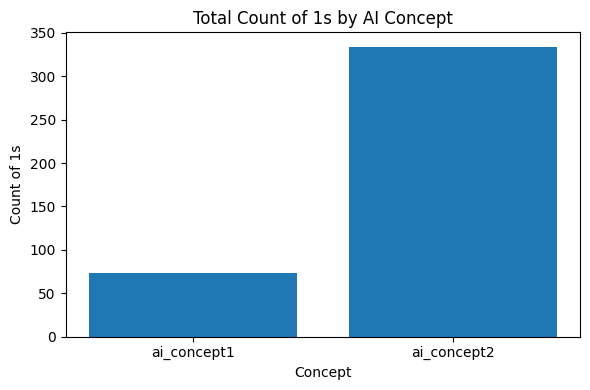

In [46]:
counts = {
    "ai_concept1": final_coded_data["ai_concept1"].sum(),
    "ai_concept2": final_coded_data["ai_concept2"].sum()
}

count_df = pd.DataFrame(list(counts.items()), columns=["Concept", "Total_1s"])

plt.figure(figsize=(6, 4))
plt.bar(count_df["Concept"], count_df["Total_1s"])
plt.title("Total Count of 1s by AI Concept")
plt.ylabel("Count of 1s")
plt.xlabel("Concept")
plt.tight_layout()
plt.show()

#### What comments received more likes?

In [47]:
def collapse(x):
    if x.ai_concept1 == 1:
        return "concept1"
    elif x.ai_concept2 == 1:
        return "concept2"
    else:
        return "neither"

final_coded_data['collapsed_codes'] = final_coded_data.apply(collapse, axis=1)

<Axes: xlabel='digg_count', ylabel='collapsed_codes'>

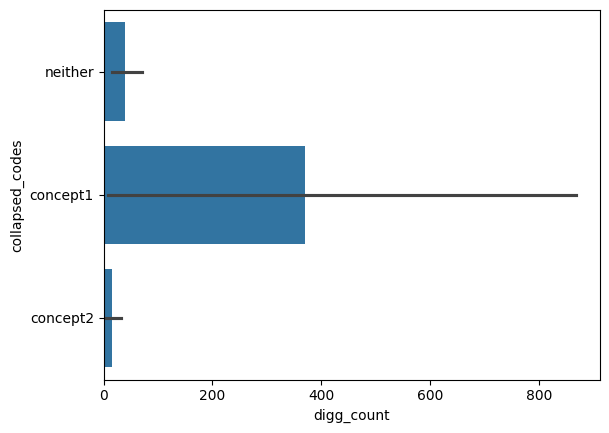

In [48]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='digg_count')

#### What comments got the most replies?

<Axes: xlabel='reply_comment_total', ylabel='collapsed_codes'>

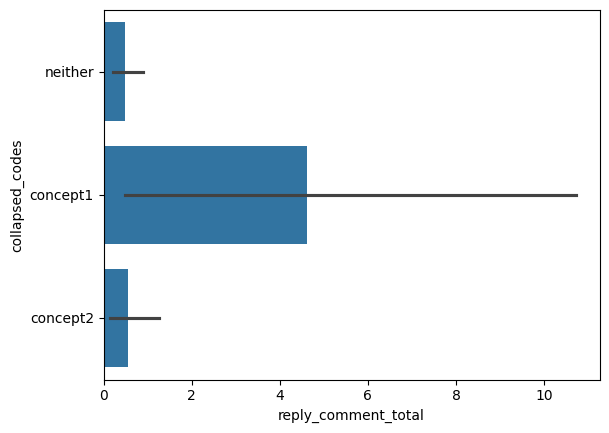

In [49]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='reply_comment_total')

#### What types of comments are shown more?
This is a visibility metric: higher scores means higher visibility in the comment section

In [50]:
final_coded_data['sort_extra_score_loaded'] = final_coded_data.sort_extra_score.apply(lambda x: ast.literal_eval(x))
final_coded_data['show_more'] = final_coded_data.sort_extra_score_loaded.apply(lambda x: float(dict(x)['show_more_score']))
sns.barplot(data=final_coded_data, y='collapsed_codes', x='show_more')

ValueError: malformed node or string: nan

#### Are there differences in age between commenters?

In [51]:
final_coded_data['users_loaded'] = final_coded_data.user.apply(lambda x: ast.literal_eval(x))
final_coded_data['age'] = final_coded_data.users_loaded.apply(
    lambda x: x['predicted_age_group'] if isinstance(x, dict) and 'predicted_age_group' in x else None
)

def reduce(x):
    try:
        return float(x)
    except:
        return float('nan')
final_coded_data['age'] = final_coded_data.age.apply(reduce)


<Axes: xlabel='age', ylabel='collapsed_codes'>

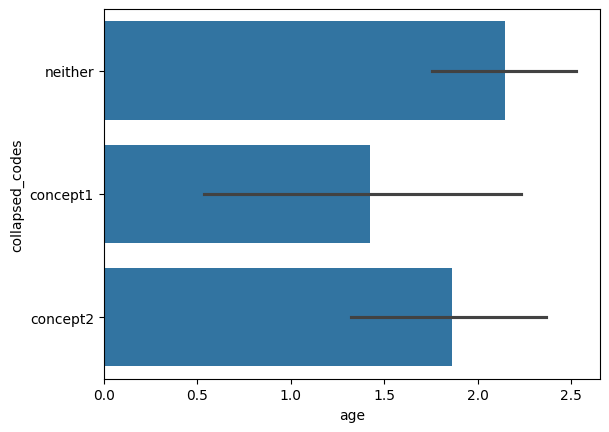

In [52]:
sns.barplot(data=final_coded_data.dropna(subset='age'), y='collapsed_codes', x='age')

- group -1 = 13-17
- group 1 = 18-24
- group 2 = 25-34
- group 3 = 35-44
- group 4 = 45-54
- group 5 = 55+

#### Use an LLM to create one more visualization or analysis
You might need to inspect your data!

## What does it all mean??
Spend 2-3 paragraphs reflecting on the results from your analysis. What are the implications of this work?